In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from model import NeuralNet
from scipy.special import softmax 
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)
np.random.seed(0)

In [2]:
data_attrs = load_iris()
data_attrs.keys()

data = data_attrs.data
y = data_attrs.target
print(data.shape, y.shape)

data_norm = (data - data.mean(axis=0)) / data.std(axis=0)

(150, 4) (150,)


In [3]:
model = NeuralNet(data=data_norm, y=y, hidden_units=2)    # Criando o modelo de Rede Neural
num_iter = 5                                              # Número de execuções para cada algoritmo

print(f'Quantidade de parâmetros da rede: {model.size(model.sample_weights())}')

Quantidade de parâmetros da rede: 19


In [4]:
# Parâmetros da Rede Neural a partir do SGD
lbfgs_loss, lbfgs_exec_time = np.zeros(num_iter), []

for i in range(num_iter):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(2,), solver='lbfgs', alpha=0.0, max_iter=2000, max_fun=50000, verbose=False)
    start = datetime.now()
    mlp_classifier.fit(data_norm, y)
    lbfgs_exec_time.append(datetime.now() - start)
    
    p = mlp_classifier.predict_proba(data_norm)
    lbfgs_loss[i] = model.cross_entropy(y, p)

In [5]:
# Parâmetros da Rede Neural a partir do Simulated Annealing
def simulated_annealing(model, N=int(1e2), K=8, T0=1e-1, eps=0.01):
    start = datetime.now()
    x_current = model.sample_weights()
    J_current = model.J(x_current)
    x_min, J_min = x_current, J_current
    history = np.zeros((2, N*K))

    for k in range(K):
        T = T0 / np.log2(2 + k)
        for n in range(N):
            x_hat = model.add_noise(x_current, eps)
            J_hat = model.J(x_hat)
            if np.random.uniform() < np.exp((J_current - J_hat) / T):
                x_current, J_current = x_hat, J_hat
            if J_hat < J_min:
                x_min, J_min = x_hat, J_hat
            history[0, N*k + n] = J_min
            history[1, N*k + n] = T
    exec_time = datetime.now() - start
    return J_min, x_min, history, exec_time

def plot_histories(histories, N, savefig=False, dt=''):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2 = ax1.twinx()
    
    for col in histories.columns[1:]:
        plot1 = ax1.plot(np.arange(histories.shape[0]), histories[col], 'b-', alpha=1., label='J Mínimo')
    ax1.set_title(f'J em função das iterações, N = {N}')
    ax1.set_ylabel('J mínimo')
    ax1.set_xlabel('Iteração')
    ax1.grid()
    plot2 = ax2.plot(np.arange(histories.shape[0]), histories['T'], 'r-', label='Temperatura')
    ax2.set_ylabel('Temperatura')

    plots = plot1 + plot2
    labels = [p.get_label() for p in plots]
    ax1.legend(plots, labels)
    
    
    if savefig:
        try: os.mkdir(f".\\images\\{dt}")
        except: pass
        fig.savefig(f'.\\images\\{dt}\\history_plot_N-{N}.png', dpi=1000)
    else: plt.show()

In [6]:
results = []

N_options = [int(1e2), int(1e3), int(1e4), int(1e5)]

start_datetime = str(datetime.now()).split('.')[0].replace(' ', '_').replace(':', '').replace('-', '')

for N in N_options:
    histories = {}
    K, T0, eps = 8, 1.0, 0.01
    for i in tqdm(range(num_iter), desc=f'N: {N}'):
        J_min, x_min, history, exec_time = simulated_annealing(model, N=N, K=K, T0=T0, eps=eps)
        results.append([N, K, T0, eps, J_min, x_min, exec_time])
        if i == 0: histories['T'] = history[1, :]
        histories[f'iter {i+1}'] = history[0, :]
    hists = pd.DataFrame(histories)
    try: os.mkdir(f".\\results\\{start_datetime}")
    except: pass
    hists.to_pickle(f".\\results\\{start_datetime}\\histories_N-{N}.pkl")
        
df = pd.DataFrame(results, columns=['N', 'K', 'T0', 'eps', 'J mínimo', 'x mínimo', 'Tempo de Execução'])
df.to_pickle(f".\\results\\{start_datetime}\\results.pkl")

N: 100:   0%|          | 0/5 [00:00<?, ?it/s]

N: 1000:   0%|          | 0/5 [00:00<?, ?it/s]

N: 10000:   0%|          | 0/5 [00:00<?, ?it/s]

N: 100000:   0%|          | 0/5 [00:00<?, ?it/s]

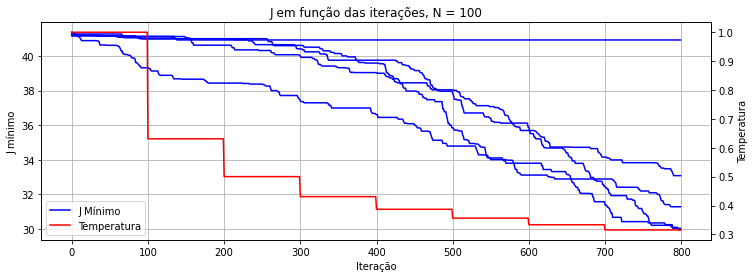

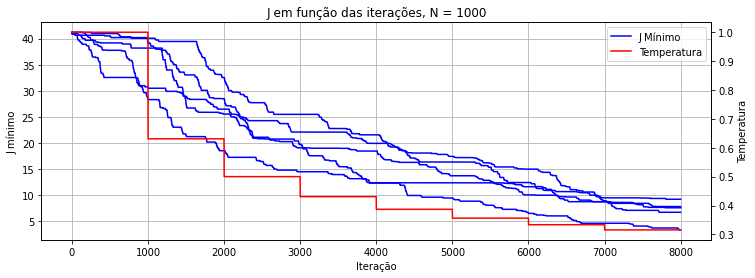

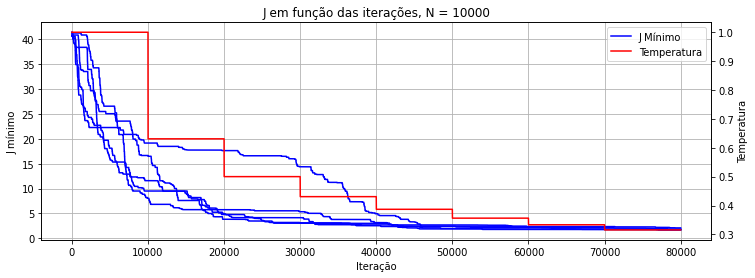

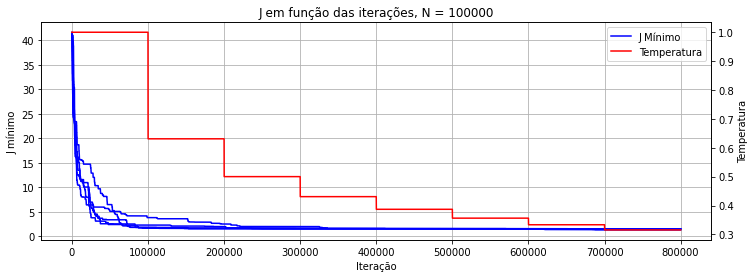

In [7]:
# start_datetime = '20220507_143854'

for N in N_options:
    histories = pd.read_pickle(f'.\\results\\{start_datetime}\\histories_N-{N}.pkl')
    plot_histories(histories, N, savefig=True, dt=start_datetime)

In [8]:
df = pd.read_pickle(f'.\\results\\{start_datetime}\\results.pkl')

# L-BFGS
print(f'L-BFGS, J_mínimo: {np.round(lbfgs_loss.mean(), 4)} +/- {np.round(lbfgs_loss.std(), 4)}, Tempo de execução médio: {np.mean(lbfgs_exec_time)}')
print()

# Simulated Annealing
for N in N_options:
    print(f'N: {N}', end=', ')
    J_mean, J_std = df[df['N'] == N]['J mínimo'].mean(), df[df['N'] == N]['J mínimo'].std()
    t_mean = df[df['N'] == N]['Tempo de Execução'].mean().to_pytimedelta()
    
    print(f"J_mínimo: {np.round(J_mean, 4)} +/- {np.round(J_std, 4)}", end=', ')
    print(f"Tempo de execução médio: {t_mean}")

L-BFGS, J_mínimo: 1.7579 +/- 0.5624, Tempo de execução médio: 0:00:00.038748

N: 100, J_mínimo: 33.0562 +/- 4.5794, Tempo de execução médio: 0:00:00.147210
N: 1000, J_mínimo: 6.9188 +/- 2.2031, Tempo de execução médio: 0:00:01.437525
N: 10000, J_mínimo: 1.835 +/- 0.1634, Tempo de execução médio: 0:00:12.885247
N: 100000, J_mínimo: 1.4596 +/- 0.1004, Tempo de execução médio: 0:01:56.726880


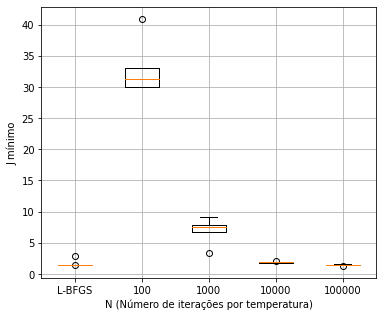

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot([lbfgs_loss.tolist()] + [df[df['N'] == N]['J mínimo'] for N in N_options], labels=['L-BFGS'] + N_options)
ax.grid()
ax.set_ylabel('J mínimo')
ax.set_xlabel('N (Número de iterações por temperatura)')
plt.show()

In [10]:
idx = num_iter * (len(N_options) - 1) + df[df['N'] == N_options[-1]]['J mínimo'].argmin()
x_min = df.iloc[idx, 5]
df.iloc[idx, :]

N                                                               100000
K                                                                    8
T0                                                                 1.0
eps                                                               0.01
J mínimo                                                      1.280283
x mínimo             {'layer_0': {'weights': [[0.3567 1.6648], [2.0...
Tempo de Execução                               0 days 00:01:51.131091
Name: 17, dtype: object

In [11]:
print(np.hstack([model(data_norm, x_min)[:50], model(data_norm, x_min)[50:100], model(data_norm, x_min)[100:]]))

[[1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0.     0.     0.     1.     0.     0.0025 0.0178 0.9797]
 [1.     0

In [12]:
bests = df.iloc[[i*num_iter + df[df['N'] == N]['J mínimo'].argmin() for i, N in enumerate(N_options)], :]
bests

,N,K,T0,eps,J mínimo,x mínimo,Tempo de Execução
0,100,8,1.0,0.01,29.946392,"{'layer_0': {'weights': [[-0.3685 -0.0778], [0...",0 days 00:00:00.151830
8,1000,8,1.0,0.01,3.320187,"{'layer_0': {'weights': [[-0.027 1.1243], [-...",0 days 00:00:01.410110
11,10000,8,1.0,0.01,1.694811,"{'layer_0': {'weights': [[0.1589 0.1693], [0.3...",0 days 00:00:14.462702
17,100000,8,1.0,0.01,1.280283,"{'layer_0': {'weights': [[0.3567 1.6648], [2.0...",0 days 00:01:51.131091


In [14]:
x_min

{'layer_0': {'weights': array([[  0.3567,   1.6648],
         [  2.0929,   1.5211],
         [-10.4037, -14.6902],
         [ -7.3174,  -6.6089]]),
  'bias': array([-2.9255, 13.7945])},
 'layer_1': {'weights': array([[  1.1896, -12.6488,   3.9239],
         [ -5.0606,   0.2778, -14.9355]]),
  'bias': array([3.8097, 5.7749, 9.7826])}}